In [2]:
pip install SimpleITK

Note: you may need to restart the kernel to use updated packages.


In [87]:
import SimpleITK as sitk
import numpy as np
from scipy import ndimage
import math
import cv2
import random
import sys
import math
import requests
import matplotlib.pyplot as plt
import tensorflow as tf


## Here i am uploading an image

In [6]:
image = sitk.ReadImage("../picai_public_images_fold1/10010/10010_1000010_t2w.mha") #need to add ../ to go up one directory

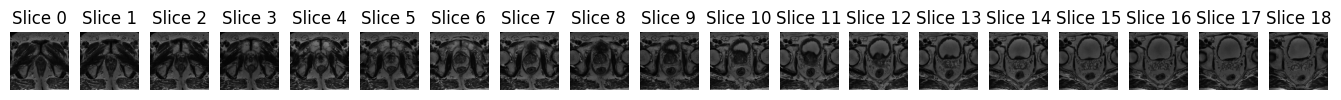

In [7]:
#this is to display the image
image_array = sitk.GetArrayFromImage(image)

# Display slices of the image using Matplotlib
num_slices = image_array.shape[0]  # Assuming the first dimension is the number of slices
fig, axes = plt.subplots(1, num_slices, figsize=(17, 4))
for i in range(num_slices):
    axes[i].imshow(image_array[i], cmap='gray')
    axes[i].axis('off')
    axes[i].set_title(f"Slice {i}")
plt.show()

In [8]:
pip install nibabel

Note: you may need to restart the kernel to use updated packages.


## now trying to get all pictures into one file

In [75]:
import os
import SimpleITK as sitk

dict_images = {}

directory = "/Users/kimberlyllajarunaperalta/Documents/ComputerVision/project/picai_public_images_fold1"

for folder in os.listdir(directory):
    folder_path = os.path.join(directory, folder) # /Users/kimberlyllajarunaperalta/Documents/ComputerVision/project/picai_public_images_fold1/10010/10010_1000010
    # print(folder_path)
    if os.path.isdir(folder_path):
        for file_name in os.listdir(folder_path):
            # print(file_name)
            if "t2w" in file_name and file_name.endswith('.mha'):
                full_path = os.path.join(directory, folder, file_name)
                if os.path.exists(full_path):
                    # print(f"Found file: {full_path}")
                    short_name = '_'.join(file_name.split('_')[:2])
                    image = sitk.ReadImage(full_path)
                    dict_images[short_name] = {'image': image, 'case_pca': None}
                # else:
                #     print(f"File not found: {full_path}")




In [60]:
dict_images['10010_1000010']

<SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'itk::simple::Image *' at 0x3415ea730> >

In [58]:
#size of the dictionary
len(dict_images)

298

## so there is 2 things: the nii files that on my understading have the color coded images and the csv file that have the labels for each image

### here is my attempt to open the nii files but it is not showing right

In [9]:
import nibabel as nib


In [12]:
path = '../10035_1000035.nii'

In [13]:
img = nib.load(path).get_fdata()
img.shape

(384, 384, 27)

In [14]:
print(f"The .nii files are stored in memory as numpy's: {type(img)}.")


The .nii files are stored in memory as numpy's: <class 'numpy.memmap'>.


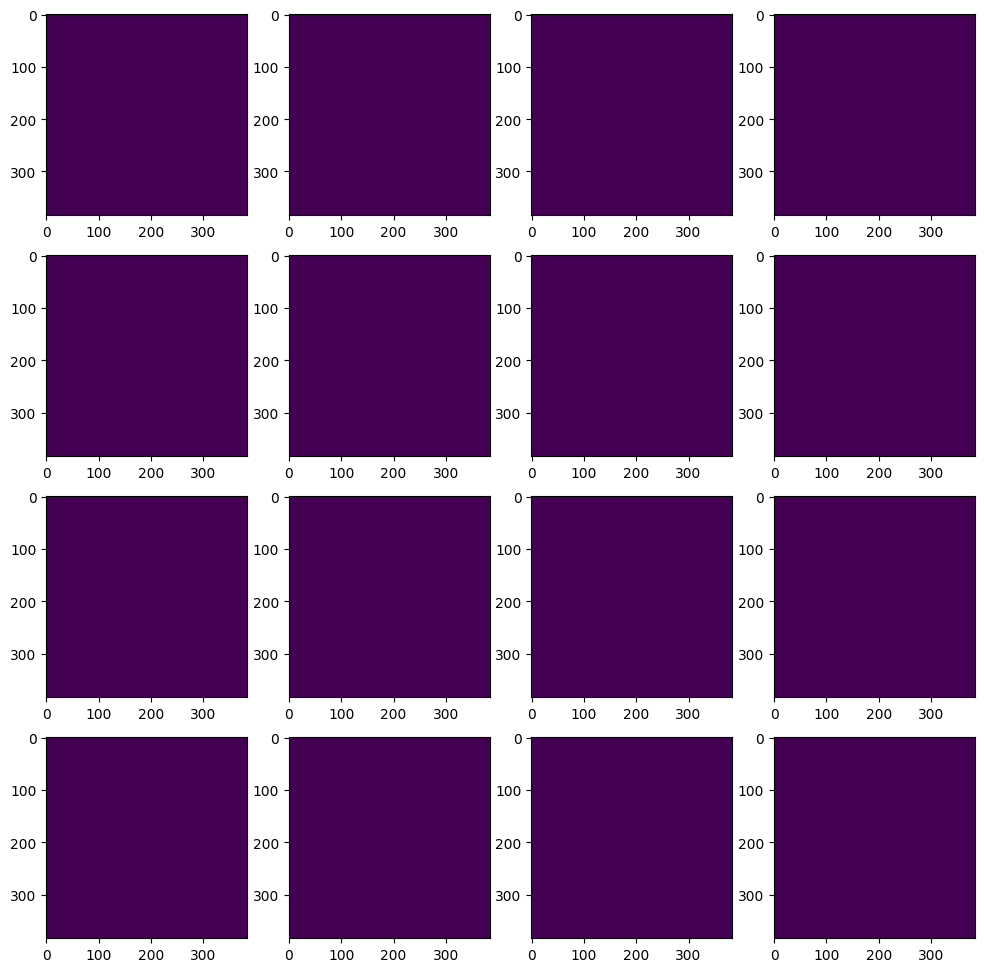

In [15]:
plt.style.use('default')
fig, axes = plt.subplots(4,4, figsize=(12,12))
for i, ax in enumerate(axes.reshape(-1)):
    ax.imshow(img[:,:,1 + i])
plt.show()

### i will try to open the csv file and see if i can get the labels

In this spreadsheet, there is a column "lesion_GS", which lists the outcomes:

Gleason score (GS) assigned to each lesion after histopathologic analysis, where scores for different lesions are separated by , (commas). If its value is missing, then no tissue sampling procedure was performed; indicating a negative MRI study. If its value is N/A only for specific lesion(s), then those lesion(s) (as observed in radiology) were not biopsied or graded in histopathology (typically the case for PI-RADS 1-2 lesions).

This means that any case that contains a Gleason score of 7 (3+4 or higher) harbors csPCa, while all other cases are considered negative for csPCa. For more details on how this ground truth was derived, you can also check out our study design.


In [17]:
#opening the csv file
import pandas as pd
df = pd.read_csv("../marksheet.csv")

In [59]:
df.head(100)

,patient_id,study_id,mri_date,patient_age,psa,psad,prostate_volume,histopath_type,lesion_GS,lesion_ISUP,case_ISUP,case_csPCa
0,10000,1000000,2019-07-02,73,7.70,NaN,55.0,MRBx,0+0,0,0,NO
1,10001,1000001,2016-05-27,64,8.70,0.09,102.0,NaN,NaN,NaN,0,NO
2,10002,1000002,2021-04-18,58,4.20,0.06,74.0,NaN,NaN,NaN,0,NO
3,10003,1000003,2019-04-05,72,13.00,NaN,71.5,SysBx,0+0,0,0,NO
4,10004,1000004,2020-10-21,67,8.00,0.10,78.0,SysBx+MRBx,"0+0,0+0","0,0",0,NO
...,...,...,...,...,...,...,...,...,...,...,...,...
95,10095,1000095,2017-02-09,65,9.20,NaN,60.0,MRBx,0+0,0,0,NO
96,10096,1000096,2011-12-31,64,22.33,0.66,34.0,MRBx,0+0,0,0,NO
97,10097,1000097,2018-11-27,66,15.01,NaN,32.0,MRBx,3+4,2,2,YES
98,10098,1000098,2012-03-29,69,12.00,0.17,69.0,NaN,NaN,NaN,0,NO


In [19]:
#want to see how many case_csPCA are positive
df['case_csPCa'].value_counts()

NO     1075
YES     425
Name: case_csPCa, dtype: int64

Combining them both

In [61]:
#combining the columns to get the full name of the image
df['full_name'] = df['patient_id'].astype(str) + '_' + df['study_id'].astype(str)

In [62]:
df

,patient_id,study_id,mri_date,patient_age,psa,psad,prostate_volume,histopath_type,lesion_GS,lesion_ISUP,case_ISUP,case_csPCa,full_name
0,10000,1000000,2019-07-02,73,7.70,NaN,55.0,MRBx,0+0,0,0,NO,10000_1000000
1,10001,1000001,2016-05-27,64,8.70,0.09,102.0,NaN,NaN,NaN,0,NO,10001_1000001
2,10002,1000002,2021-04-18,58,4.20,0.06,74.0,NaN,NaN,NaN,0,NO,10002_1000002
3,10003,1000003,2019-04-05,72,13.00,NaN,71.5,SysBx,0+0,0,0,NO,10003_1000003
4,10004,1000004,2020-10-21,67,8.00,0.10,78.0,SysBx+MRBx,"0+0,0+0","0,0",0,NO,10004_1000004
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,11471,1001495,2012-08-25,71,12.50,0.21,62.0,MRBx,"3+4,N/A,3+3","2,1",2,YES,11471_1001495
1496,11472,1001496,2019-06-28,81,5.28,0.12,44.0,SysBx+MRBx,3+4,2,2,YES,11472_1001496
1497,11473,1001497,2017-09-24,56,29.60,0.34,87.0,MRBx,0+0,0,0,NO,11473_1001497
1498,11474,1001498,2016-05-03,71,12.00,NaN,83.0,MRBx,3+3,1,1,NO,11474_1001498


In [68]:
specific_full_name = '10000_1000000'
case_csPCA_value = df.loc[df['full_name'] == specific_full_name, 'case_csPCa'].iloc[0]
case_csPCA_value

'NO'

In [76]:
## now adding to dictinary based on full name
not_found = 0
found = 0
for f in df['full_name']:
    if f in dict_images:
        print(f"Found {f}")
        dict_images[f]['case_pca'] = df.loc[df['full_name'] == f, 'case_csPCa'].iloc[0]

        found += 1
    else:
        print(f"Could not find {f}")
        not_found += 1

Could not find 10000_1000000
Could not find 10001_1000001
Could not find 10002_1000002
Could not find 10003_1000003
Could not find 10004_1000004
Could not find 10005_1000005
Could not find 10006_1000006
Could not find 10007_1000007
Found 10008_1000008
Could not find 10009_1000009
Found 10010_1000010
Found 10011_1000011
Could not find 10012_1000012
Could not find 10013_1000013
Could not find 10014_1000014
Could not find 10015_1000015
Found 10016_1000016
Could not find 10017_1000017
Could not find 10018_1000018
Found 10019_1000019
Could not find 10020_1000020
Could not find 10021_1000021
Could not find 10022_1000022
Could not find 10023_1000023
Found 10024_1000024
Could not find 10025_1000025
Found 10026_1000026
Could not find 10027_1000027
Could not find 10028_1000028
Could not find 10029_1000029
Could not find 10030_1000030
Found 10031_1000031
Could not find 10032_1000032
Could not find 10033_1000033
Could not find 10034_1000034
Could not find 10035_1000035
Found 10036_1000036
Could no

In [77]:
found, not_found

(298, 1202)

In [78]:
#our dictionary with the T2w images and the case_csPCa values
dict_images

{'10268_1000272': {'image': <SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'itk::simple::Image *' at 0x33d8d6e50> >,
  'case_pca': 'YES'},
 '10892_1000908': {'image': <SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'itk::simple::Image *' at 0x33d8d6a00> >,
  'case_pca': 'NO'},
 '11385_1001409': {'image': <SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'itk::simple::Image *' at 0x32bb516e0> >,
  'case_pca': 'YES'},
 '10401_1000407': {'image': <SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'itk::simple::Image *' at 0x32bb52f40> >,
  'case_pca': 'NO'},
 '11371_1001394': {'image': <SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'itk::simple::Image *' at 0x32bb53390> >,
  'case_pca': 'NO'},
 '10895_1000911': {'image': <SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'itk::simple::Image *' at 0x3415d85a0> >,
  'case_pca': 'YES'},
 '11376_1001399': {'image': <SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'itk::simple::Ima

In [79]:
dict_images['10010_1000010']

{'image': <SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'itk::simple::Image *' at 0x45ca2e7f0> >,
 'case_pca': 'NO'}

## Some basic preprocessing of the images

# Training a basic ResNet model

this was with the whole dataset, now i will try to do the same with the 1 images

In [89]:
model = tf.keras.applications.ResNet50()


In [97]:
#split the data into training and testing
from sklearn.model_selection import train_test_split
images = [entry['image'] for entry in dict_images.values()]
labels = [entry['case_pca'] for entry in dict_images.values()]
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

In [103]:
from torchvision import datasets, models, transforms

23


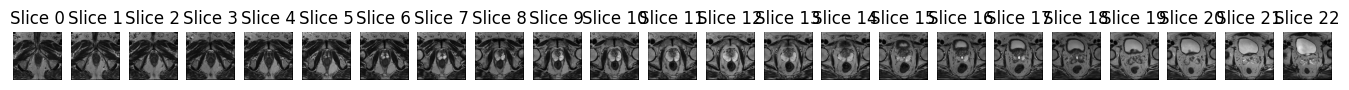

In [107]:
#this is to display the image
image_array = sitk.GetArrayFromImage(images[0])

# Display slices of the image using Matplotlib
num_slices = image_array.shape[0]  # Assuming the first dimension is the number of slices
print(num_slices)
fig, axes = plt.subplots(1, num_slices, figsize=(17, 4))
for i in range(num_slices):
    axes[i].imshow(image_array[i], cmap='gray')
    axes[i].axis('off')
    axes[i].set_title(f"Slice {i}")
plt.show()

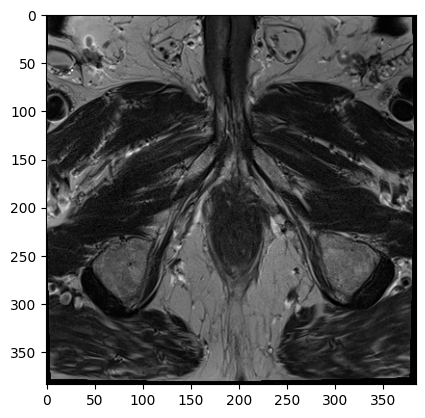

In [117]:
#now just picking up the first slice

image_array = sitk.GetArrayFromImage(images[0])
plt.imshow(image_array[0, :, :], cmap='gray')

In [ ]:
data_transform =   transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
#         transforms.Normalize(mean=[0.0, 0.0, 0.0],
#                                  std=[1, 1, 1])
    ])

In [121]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

# Load pre-trained ResNet-50 model without top layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

94765736/94765736 [==============================] - 10s 0us/step


In [122]:
def forresnet(image_sample):
    """
    Preprocess the image for ResNet-50 model
    
    """
    # Assuming images[0] is a SimpleITK image
    image_sitk = image_sample

    # Selecting a single slice (e.g., the first slice)
    single_slice = image_sitk[0, :, :]

    # Convert SimpleITK image to numpy array
    image_array = sitk.GetArrayFromImage(single_slice)
    print("Original shape:", image_array.shape)  # (23, 384)

    # Reshape to add an extra dimension
    image_array = np.expand_dims(image_array, axis=-1)
    print("Shape after adding dimension:", image_array.shape)  # (23, 384, 1)

    # Resize the image to (224, 224)
    image_array = tf.image.resize(image_array, (224, 224))
    print("Resized shape:", image_array.shape)  # (224, 224, 1)

    # Remove the extra dimension
    image_array = tf.squeeze(image_array, axis=-1)
    print("Shape after squeezing:", image_array.shape)  # (224, 224)

    # Stack to create a 3-channel image
    image_array = tf.stack([image_array] * 3, axis=-1)
    print("Shape after stacking:", image_array.shape)  # (224, 224, 3)

    # Normalize the image
    image_array = image_array / 255.0
    print("Shape after normalization:", image_array.shape)

    # Add batch dimension
    image_array = tf.expand_dims(image_array, axis=0)
    print("Final shape with batch dimension:", image_array.shape)

    return image_array



In [119]:
import SimpleITK as sitk
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import resnet50

# Assuming images[0] is a SimpleITK image
image_sitk = images[0]

# Selecting a single slice (e.g., the first slice)
single_slice = image_sitk[0, :, :]

# Convert SimpleITK image to numpy array
image_array = sitk.GetArrayFromImage(single_slice)
print("Original shape:", image_array.shape)  # (23, 384)

# Reshape to add an extra dimension
image_array = np.expand_dims(image_array, axis=-1)
print("Shape after adding dimension:", image_array.shape)  # (23, 384, 1)

# Resize the image to (224, 224)
image_array = tf.image.resize(image_array, (224, 224))
print("Resized shape:", image_array.shape)  # (224, 224, 1)

# Remove the extra dimension
image_array = tf.squeeze(image_array, axis=-1)
print("Shape after squeezing:", image_array.shape)  # (224, 224)

# Stack to create a 3-channel image
image_array = tf.stack([image_array] * 3, axis=-1)
print("Shape after stacking:", image_array.shape)  # (224, 224, 3)

# Normalize the image
image_array = image_array / 255.0
print("Shape after normalization:", image_array.shape)

# Add batch dimension
image_array = tf.expand_dims(image_array, axis=0)
print("Final shape with batch dimension:", image_array.shape)

# Load the pre-trained ResNet-50 model
model = resnet50.ResNet50(weights='imagenet')

# Make a prediction with the ResNet model
predictions = model.predict(image_array)

# Print the predictions
print(predictions)


Original shape: (23, 384)
Shape after adding dimension: (23, 384, 1)
Resized shape: (224, 224, 1)
Shape after squeezing: (224, 224)
Shape after stacking: (224, 224, 3)
Shape after normalization: (224, 224, 3)
Final shape with batch dimension: (1, 224, 224, 3)
1/1 [==============================] - 1s 502ms/step
[[1.69642342e-04 3.30074516e-04 6.13505108e-05 1.05807383e-04
  5.37968699e-05 5.24695439e-04 9.60743364e-06 3.61798047e-05
  1.73299486e-05 1.45301223e-04 7.16274430e-04 1.41580036e-04
  5.88391413e-05 8.10714628e-05 1.67477538e-05 4.96861685e-05
  1.25103063e-04 2.92707282e-05 5.74158148e-05 4.94917476e-05
  1.98916736e-04 1.61658274e-03 9.80363460e-04 2.24181640e-04
  8.84685796e-05 1.15410156e-04 3.21867788e-04 2.37414541e-04
  1.77072463e-04 1.91081490e-04 4.38325005e-05 3.40471190e-04
  9.16090939e-05 1.15454684e-04 2.90877768e-04 1.64524790e-05
  1.24186103e-04 1.11319650e-05 5.98711753e-03 3.84913546e-05
  4.93699845e-05 1.99962364e-04 2.39033703e-04 1.63909237e-04
  5.5